# Problem Set 1 (Take Home) - 40 points

## PS 1.A - 20 points

In [this video](https://www.youtube.com/watch?v=ho6JXE3EbZ8) the author explains how to extract various visualizations of what CNNs learn. [Your course site](https://pantelis.github.io/artificial-intelligence/aiml-common/lectures/cnn/cnn-example-architectures/visualizing-what-convnets-learn.html) also covers the topic. 

Using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), train a ResNet-50 based CNN on the classification task of $K=9$ classes (filter out the class `ship`) and create the following visualizations for first, middle and last blocks of ResNet-50. You are free to select a class to showcase such visualizations.

* Visualizing intermediate convnet outputs (“intermediate activations”). This is useful to understand how successive convnet layers transform their input.

* Visualizing convnets filters. This is useful to understand precisely what visual pattern or concept each filter in a convnet is receptive to.

* Visualizing heatmaps of class activation in an image. This is useful to understand which part of an image where identified as belonging to a given class, and thus allows to localize objects in images.


In [1]:
import warnings
warnings.filterwarnings('ignore')

from typing import Callable, List, Optional, Type

import copy
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import v2

In [2]:
# Global variables
ROOT = '../../datasets/'

BATCH_SIZE = 32
NUM_EPOCH = 15
LR = 1e-4
DEVICE = 'cuda:1'

In [3]:
# Reference: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
# Made some modifications, using nn.Sequential to encapsulate calculations in order to add hooks in sequence.

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, padding: int = 1) -> nn.Conv2d:
    return nn.Conv2d(
        in_channels=in_planes,
        out_channels=out_planes,
        kernel_size=3,
        stride=stride,
        padding=padding,
        groups=groups,
        bias=False,
        dilation=padding
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    return nn.Conv2d(
        in_channels=in_planes,
        out_channels=out_planes,
        kernel_size=1,
        stride=stride,
        bias=False
    )


class Bottleneck(nn.Module):
    expansion: int = 4

    def __init__(
            self,
            inplanes: int,
            outplanes: int,
            stride: int = 1,
            downsample: Optional[nn.Module] = None,
            groups: int = 1,
            base_width: int = 64,
            dilation: int = 1,
            norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(outplanes * (base_width / 64.0)) * groups
        self.seq = nn.Sequential(
            conv1x1(inplanes, width),
            norm_layer(width),
            nn.ReLU(inplace=True),
            conv3x3(width, width, stride, groups, dilation),
            norm_layer(width),
            nn.ReLU(inplace=True),
            conv1x1(width, outplanes * self.expansion),
            norm_layer(outplanes * self.expansion),
        )
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.seq(x)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
            self,
            block: Type[Bottleneck],
            layers: List[int],
            num_classes: int = 1000,
            zero_init_residual: bool = False,
            groups: int = 1,
            width_per_group: int = 64,
            replace_stride_with_dilation: Optional[List[bool]] = None,
            norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]

        self.groups = groups
        self.base_width = width_per_group
        self.head = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            norm_layer(self.inplanes),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.tail = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512 * block.expansion, num_classes),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)

    def _make_layer(
            self,
            block: Type[Bottleneck],
            planes: int,
            blocks: int,
            stride: int = 1,
            dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion)
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.head(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.tail(x)

        return x



In [4]:
class CustomCIFAR10(Dataset):
    def __init__(self, original_dataset: datasets.CIFAR10, exclude_class: int, transform=None) -> None:
        self.label = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        self.original_dataset = original_dataset
        self.exclude_class = exclude_class
        self.data = self._transform_data()
        self.transform = transform

    def _transform_data(self) -> list:
        data = []
        if self.exclude_class:
            for item in self.original_dataset:
                if item[1] == self.exclude_class:
                    continue
                elif item[1] < self.exclude_class:
                    data.append((item[0], item[1]))
                else:
                    data.append((item[0], item[1] - 1))
        else:
            data = [item for item in self.original_dataset]
        return data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index) -> tuple:
        image, label = self.data[index]
        if self.transform:
            image = self.transform(image)
        return image, label

    def get_class(self, index) -> str:
        return self.label[index]



In [5]:
# Image transformer
transform = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32),
    v2.Resize((224, 224)),
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_train = datasets.CIFAR10(root=ROOT, train=True, download=True)
data_test = datasets.CIFAR10(root=ROOT, train=False, download=True)

data_train_without_ship = CustomCIFAR10(original_dataset=data_train, exclude_class=8, transform=transform)
data_test_without_ship = CustomCIFAR10(original_dataset=data_test, exclude_class=8, transform=transform)

dataloader_train_without_ship = DataLoader(data_train_without_ship, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test_without_ship = DataLoader(data_test_without_ship, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def train(model, criterion, optimizer, num_epoch, device, data_train, data_val, verbose=True):
    model = model.to(device)
    epoch_hist = []
    train_loss_hist = []
    train_acc_hist = []
    val_loss_hist = []
    val_acc_hist = []
    for epoch in range(num_epoch):
        epoch_hist.append(epoch)
        # Train
        model.train()
        train_batch_count = 0
        train_batch_loss = 0.0
        train_batch_acc = 0.0
        for images, labels in data_train:
            # To GPU
            images = images.to(device)
            labels = labels.to(device)
            # Forward
            out = model(images)
            _, pred = torch.max(out, 1)
            # Loss
            loss = criterion(out, labels)
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Record
            train_batch_count += 1
            train_batch_loss += loss
            train_batch_acc += (pred == labels).sum() / BATCH_SIZE
        # Info
        train_loss_hist.append((train_batch_loss / train_batch_count).cpu().detach().numpy())
        train_acc_hist.append((train_batch_acc / train_batch_count).cpu().detach().numpy())
        if verbose:
            print(f'Train epoch: {epoch}, avg loss: {train_loss_hist[-1]}, avg acc: {train_acc_hist[-1]}')
        # Eval
        model.eval()
        with torch.no_grad():
            val_batch_count = 0
            val_batch_loss = 0.0
            val_batch_acc = 0.0
            for images, labels in data_val:
                images = images.to(device)
                labels = labels.to(device)
                out = model(images)
                _, pred = torch.max(out, 1)
                loss = criterion(out, labels)
                val_batch_count += 1
                val_batch_loss += loss
                val_batch_acc += (pred == labels).sum() / BATCH_SIZE
            val_loss_hist.append((val_batch_loss / val_batch_count).cpu().detach().numpy())
            val_acc_hist.append((val_batch_acc / val_batch_count).cpu().detach().numpy())
            if verbose:
                print(f'Val epoch: {epoch}, avg loss: {val_loss_hist[-1]}, avg acc: {val_acc_hist[-1]}')
    return epoch_hist, train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist


def predict(model, data_test, device):
    y_true = []
    y_pred = []
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for images, labels in data_test:
            y_true.extend(labels.cpu().detach().numpy())
            images = images.to(device)
            out = model(images)
            _, pred = torch.max(out, 1)
            y_pred.extend(pred.cpu().detach().numpy())
    return y_true, y_pred



In [7]:
model = ResNet(block=Bottleneck, layers=[3, 4, 6, 3], num_classes=9)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(params=model.parameters(), lr=LR)

model_hists = train(model, criterion, optimizer, NUM_EPOCH, DEVICE, dataloader_train_without_ship, dataloader_test_without_ship)

Train epoch: 0, avg loss: 1.5146244764328003, avg acc: 0.440498411655426
Val epoch: 0, avg loss: 1.5114425420761108, avg acc: 0.45345744490623474
Train epoch: 1, avg loss: 1.0667204856872559, avg acc: 0.6148942708969116
Val epoch: 1, avg loss: 1.050123691558838, avg acc: 0.6215646862983704
Train epoch: 2, avg loss: 0.792245626449585, avg acc: 0.7196162343025208
Val epoch: 2, avg loss: 0.9990177750587463, avg acc: 0.6661125421524048
Train epoch: 3, avg loss: 0.5979962944984436, avg acc: 0.7890236377716064
Val epoch: 3, avg loss: 0.8771473169326782, avg acc: 0.6980274319648743
Train epoch: 4, avg loss: 0.4430505633354187, avg acc: 0.842595100402832
Val epoch: 4, avg loss: 1.0545774698257446, avg acc: 0.6763076186180115
Train epoch: 5, avg loss: 0.30635517835617065, avg acc: 0.8914579153060913
Val epoch: 5, avg loss: 1.1182396411895752, avg acc: 0.7016843557357788
Train epoch: 6, avg loss: 0.21535615622997284, avg acc: 0.92319655418396
Val epoch: 6, avg loss: 0.7119070887565613, avg acc: 

In [8]:
class FeatureExtractor():
    def __init__(self, model: nn.Module, layer_num: int) -> None:
        self.output = None
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output) -> None:
        self.output = output.cpu()

    def remove(self) -> None:
        self.hook.remove()



In [9]:
def plt_image(title: str, image: Tensor) -> None:
    plt.title(title)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.show()


def plt_grid(title: str, figsize: tuple, nrow: int, ncol: int, data: Tensor) -> None:
    fig, ax = plt.subplots(nrow, ncol, figsize=figsize)
    plt.suptitle(title)
    ax_flattened = ax.flatten()
    for i in range(nrow * ncol):
        ax_flattened[i].set_xticks([])
        ax_flattened[i].set_yticks([])
        ax_flattened[i].imshow(data[0, i, :, :].cpu().detach().numpy(), cmap='gray')
    plt.tight_layout()
    fig.show()


def plt_heatmap(title: str, data: Tensor) -> None:
    plt.imshow(data[0].detach().numpy(), cmap='viridis')
    plt.axis('off')
    plt.show()



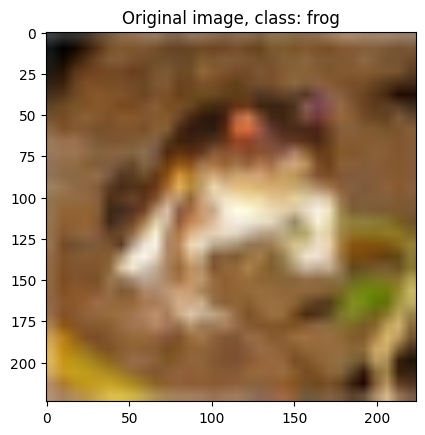

In [10]:
model.eval()
img, label = data_train_without_ship.__getitem__(0)
image = img.unsqueeze(0).to(DEVICE)

plt_image(title=f'Original image, class: {data_train_without_ship.get_class(label)}', image=img)

torch.Size([1, 64, 56, 56])


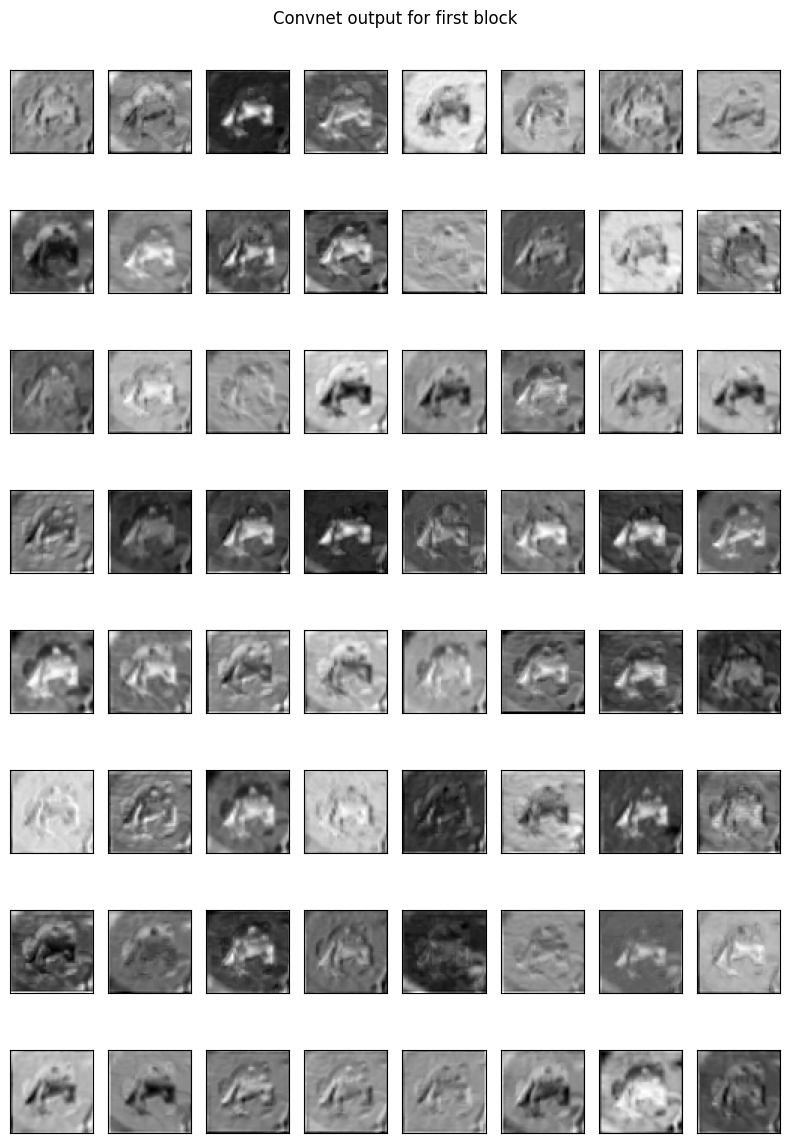

In [11]:
# Intermediate convnet outputs ('intermediate activations') visulization for first block
conv_out_first = FeatureExtractor(model.layer1[0].seq, 0)
_ = model(image)
conv_out_first.remove()
conv_out_first = conv_out_first.output

print(conv_out_first.shape)
plt_grid(title='Convnet output for first block', figsize=(8, 12), nrow=8, ncol=8, data=conv_out_first)

torch.Size([64, 64, 3, 3])


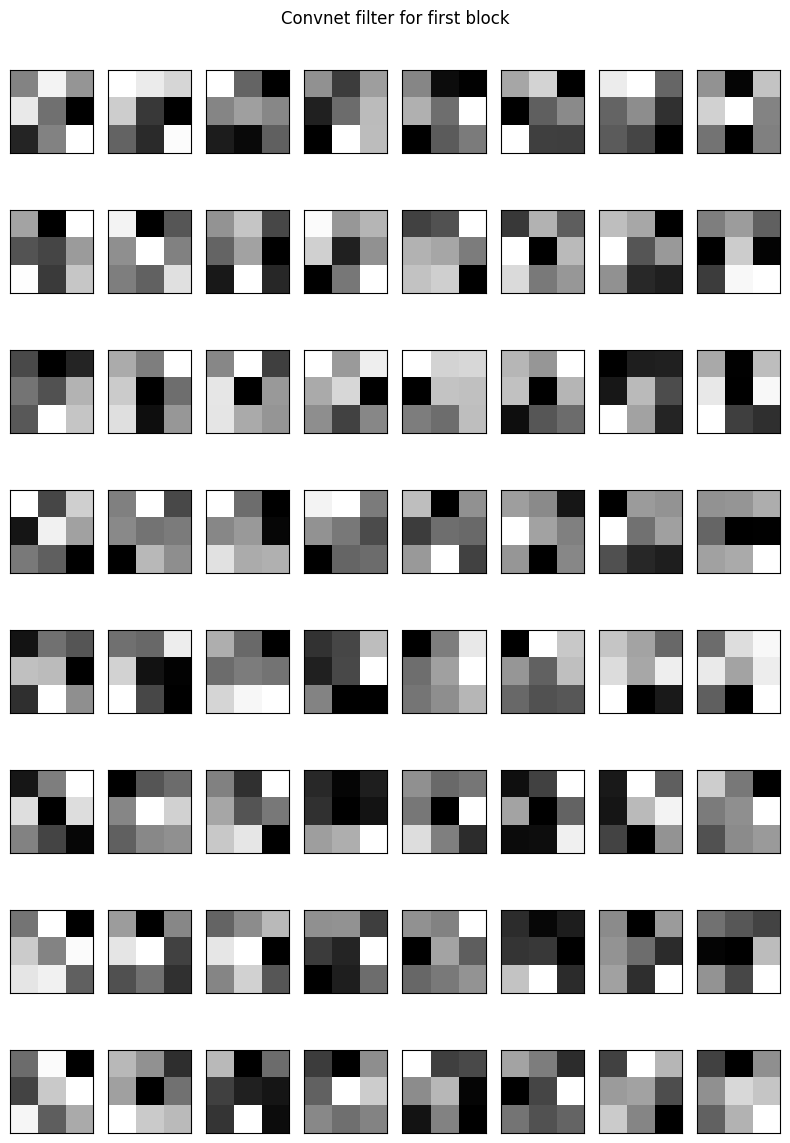

In [12]:
# Convnet filters visulization for first block
conv_filter_first = model.layer1[0].seq[3]
weight_first = next(conv_filter_first.parameters())

print(weight_first.shape)
plt_grid(title='Convnet filter for first block', figsize=(8, 12), nrow=8, ncol=8, data=weight_first)


torch.Size([1, 56, 56])


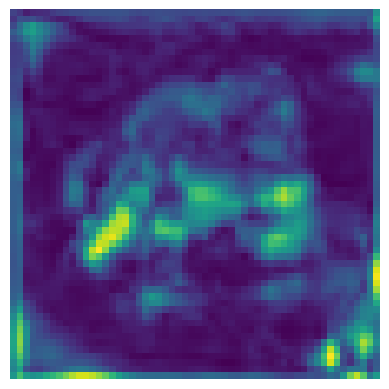

In [13]:
# Activation heatmap visulization for first block
activate_out_first = FeatureExtractor(model.layer1, 2)
_ = model(image)
activate_out_first.remove()
activate_out_first = activate_out_first.output
activate_out_first = activate_out_first.mean(dim=1)

print(activate_out_first.shape)
plt_heatmap(title='Activation heatmap for first block', data=activate_out_first)


torch.Size([1, 256, 28, 28])


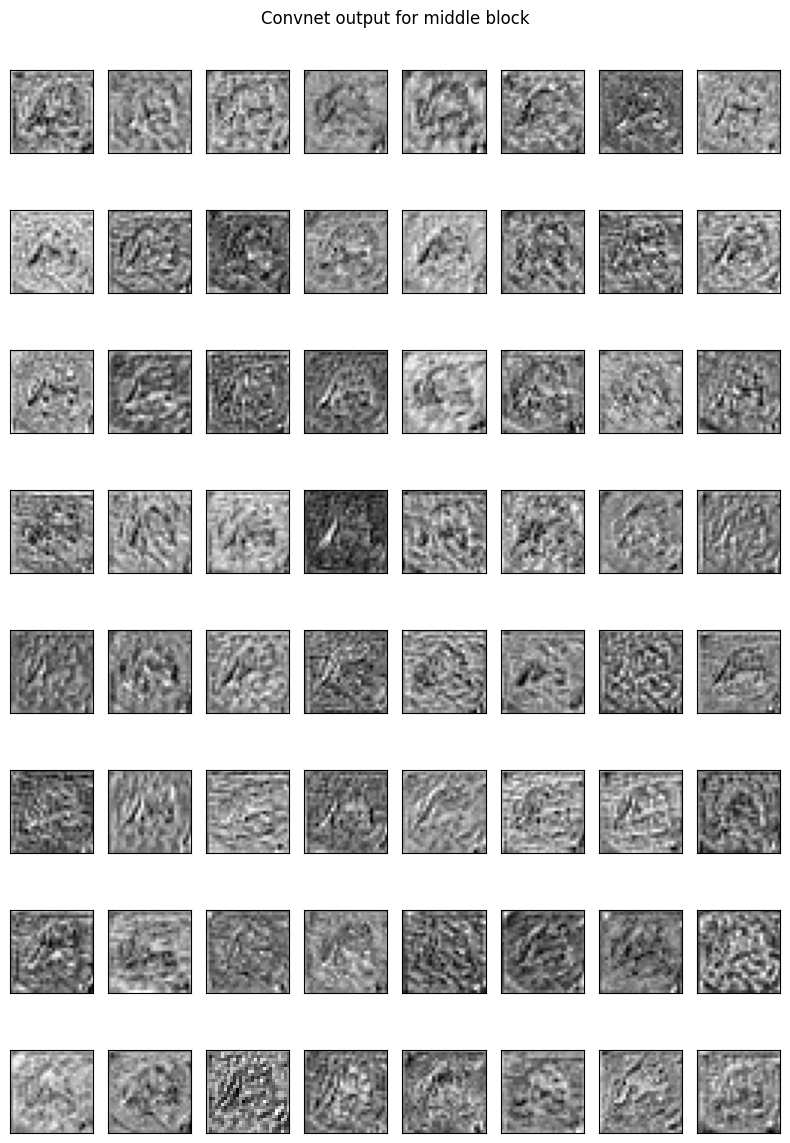

In [14]:
# Intermediate convnet outputs ('intermediate activations') visulization for middle block
conv_out_middle = FeatureExtractor(model.layer3[0].seq, 0)
_ = model(image)
conv_out_middle.remove()
conv_out_middle = conv_out_middle.output

print(conv_out_middle.shape)
plt_grid(title='Convnet output for middle block', figsize=(8, 12), nrow=8, ncol=8, data=conv_out_middle)

torch.Size([256, 256, 3, 3])


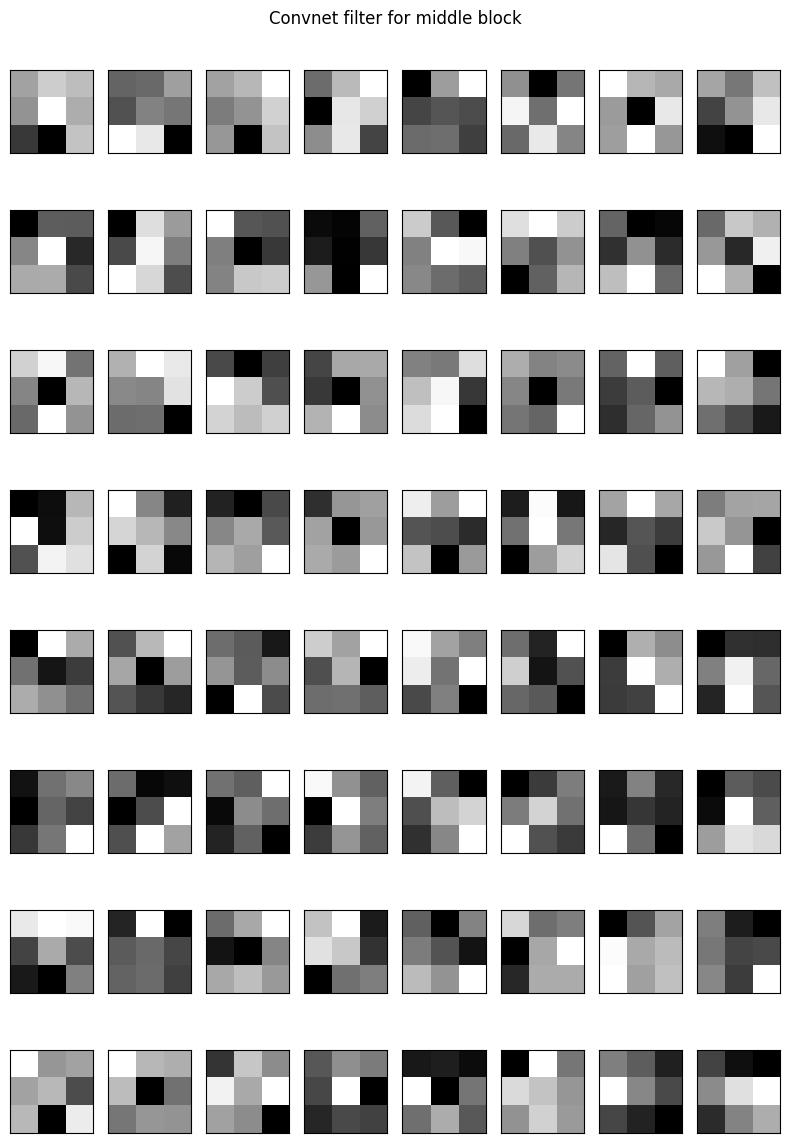

In [15]:
# Convnet filters visulization for middle block
conv_filter_middle = model.layer3[0].seq[3]
weight_middle = next(conv_filter_middle.parameters())

print(weight_middle.shape)
plt_grid(title='Convnet filter for middle block', figsize=(8, 12), nrow=8, ncol=8, data=weight_middle)

torch.Size([1, 14, 14])


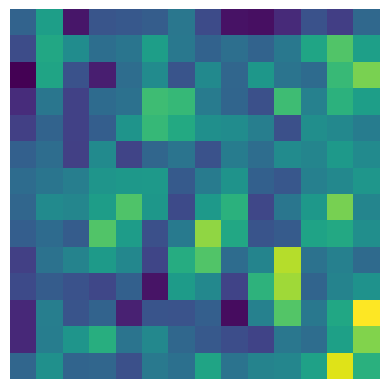

In [16]:
# Activation heatmap visulization for middle block
activate_out_middle = FeatureExtractor(model.layer3, 5)
_ = model(image)
activate_out_middle.remove()
activate_out_middle = activate_out_middle.output
activate_out_middle = activate_out_middle.mean(dim=1)

print(activate_out_middle.shape)
plt_heatmap(title='Activation heatmap for middle block', data=activate_out_middle)

torch.Size([1, 512, 14, 14])


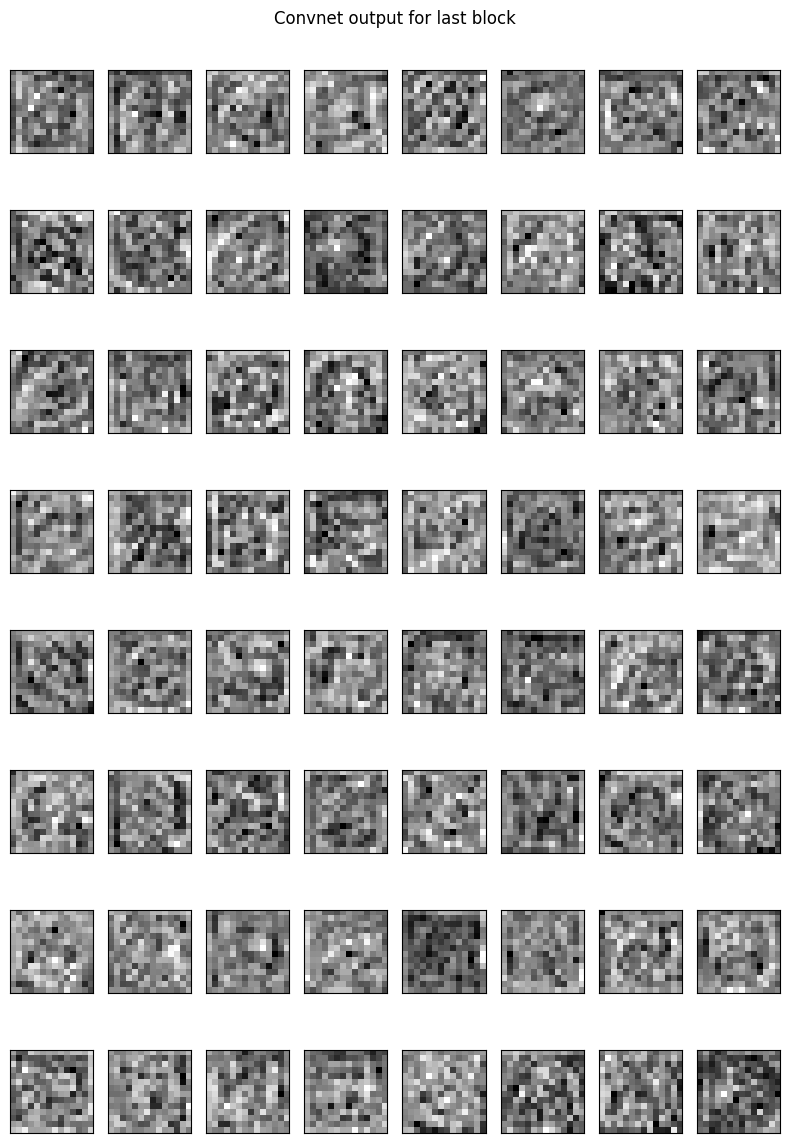

In [17]:
# Intermediate convnet outputs ('intermediate activations') visulization for last block
conv_out_last = FeatureExtractor(model.layer4[0].seq, 0)
_ = model(image)
conv_out_last.remove()
conv_out_last = conv_out_last.output

print(conv_out_last.shape)
plt_grid(title='Convnet output for last block', figsize=(8, 12), nrow=8, ncol=8, data=conv_out_last)

torch.Size([512, 512, 3, 3])


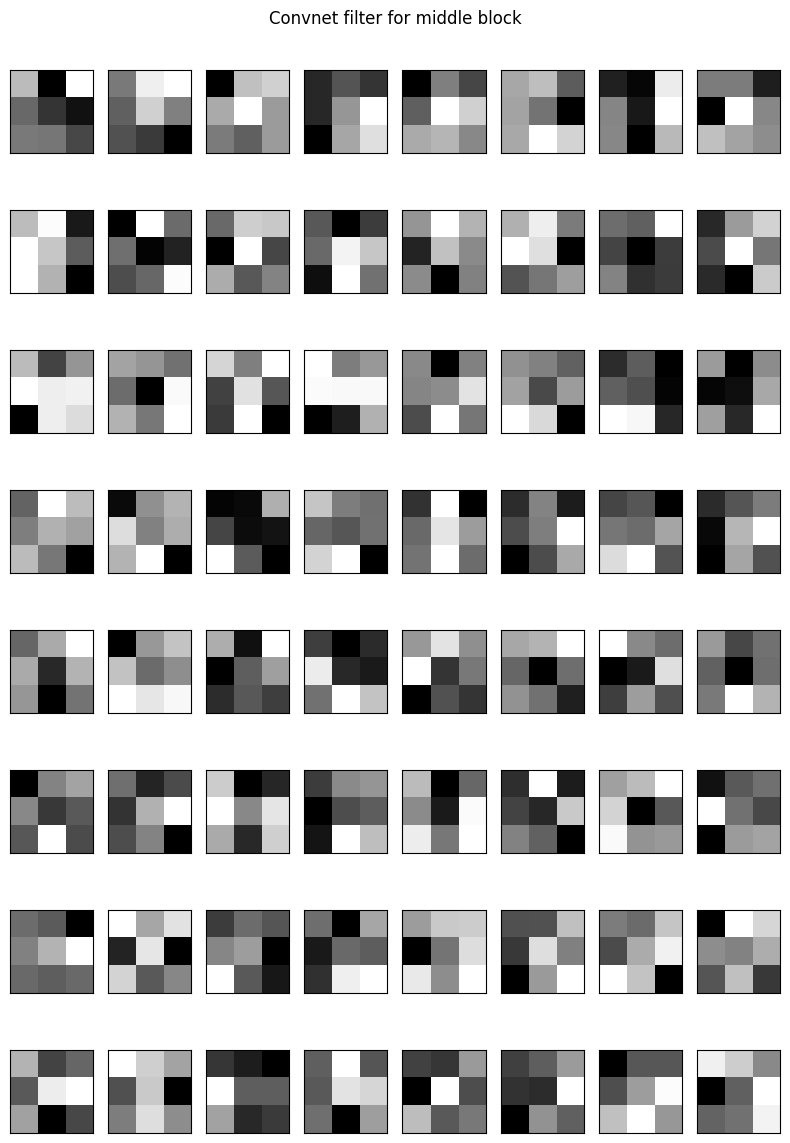

In [18]:
# Convnet filters visulization for last block
conv_filter_last = model.layer4[0].seq[3]
weight_last = next(conv_filter_last.parameters())

print(weight_last.shape)
plt_grid(title='Convnet filter for middle block', figsize=(8, 12), nrow=8, ncol=8, data=weight_last)

torch.Size([1, 7, 7])


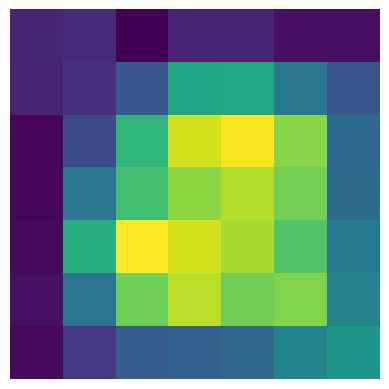

In [19]:
# Activation heatmap visulization for last block
activate_out_last = FeatureExtractor(model.layer4, 2)
_ = model(image)
activate_out_last.remove()
activate_out_last = activate_out_last.output
activate_out_last = activate_out_last.mean(dim=1)

print(activate_out_last.shape)
plt_heatmap(title='Activation heatmap for last block', data=activate_out_last)

## PS 1.B - 20 points

In [this notebook](https://pantelis.github.io/artificial-intelligence/aiml-common/lectures/transfer-learning/transfer_learning_tutorial.html) we showcase _transfer learning_ using a pre-trained CNN model. 

Perform the fine-tunning and feature extraction methods of transfer learning using the same model as in PS-1A, for the class `ship`. 

Repeat the visualization of PS-1.A before and after  transfer learning and write a conclusive summary as to the relative value of the two methods.

In [20]:
data_train_all = CustomCIFAR10(original_dataset=data_train, exclude_class=None, transform=transform)
data_test_all = CustomCIFAR10(original_dataset=data_test, exclude_class=None, transform=transform)

dataloader_train = DataLoader(data_train_all, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(data_test_all, batch_size=BATCH_SIZE, shuffle=False)

In [21]:
model_ft = copy.deepcopy(model)
for param in model_ft.parameters():
    param.requires_grad = False

num_features = model_ft.tail[2].in_features
model_ft.tail[2] = nn.Linear(num_features, 10)

criterion_ft = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.RMSprop(params=model_ft.parameters(), lr=LR)
model_ft_hists = train(model_ft, criterion_ft, optimizer_ft, NUM_EPOCH, DEVICE, dataloader_train, dataloader_test)

Train epoch: 0, avg loss: 0.2786933481693268, avg acc: 0.9235444664955139
Val epoch: 0, avg loss: 0.6798586249351501, avg acc: 0.7832468152046204
Train epoch: 1, avg loss: 0.16050909459590912, avg acc: 0.9426183700561523
Val epoch: 1, avg loss: 0.7401190996170044, avg acc: 0.785243570804596
Train epoch: 2, avg loss: 0.1460568606853485, avg acc: 0.946077287197113
Val epoch: 2, avg loss: 0.7461385130882263, avg acc: 0.7927316427230835
Train epoch: 3, avg loss: 0.13963492214679718, avg acc: 0.9480366110801697
Val epoch: 3, avg loss: 0.7511168718338013, avg acc: 0.7959265112876892
Train epoch: 4, avg loss: 0.13168829679489136, avg acc: 0.9506957530975342
Val epoch: 4, avg loss: 0.7599650025367737, avg acc: 0.7987220287322998
Train epoch: 5, avg loss: 0.12807579338550568, avg acc: 0.9529750347137451
Val epoch: 5, avg loss: 0.7925986051559448, avg acc: 0.793430507183075
Train epoch: 6, avg loss: 0.12561339139938354, avg acc: 0.954034686088562
Val epoch: 6, avg loss: 0.7756047248840332, avg a

torch.Size([1, 512, 14, 14])


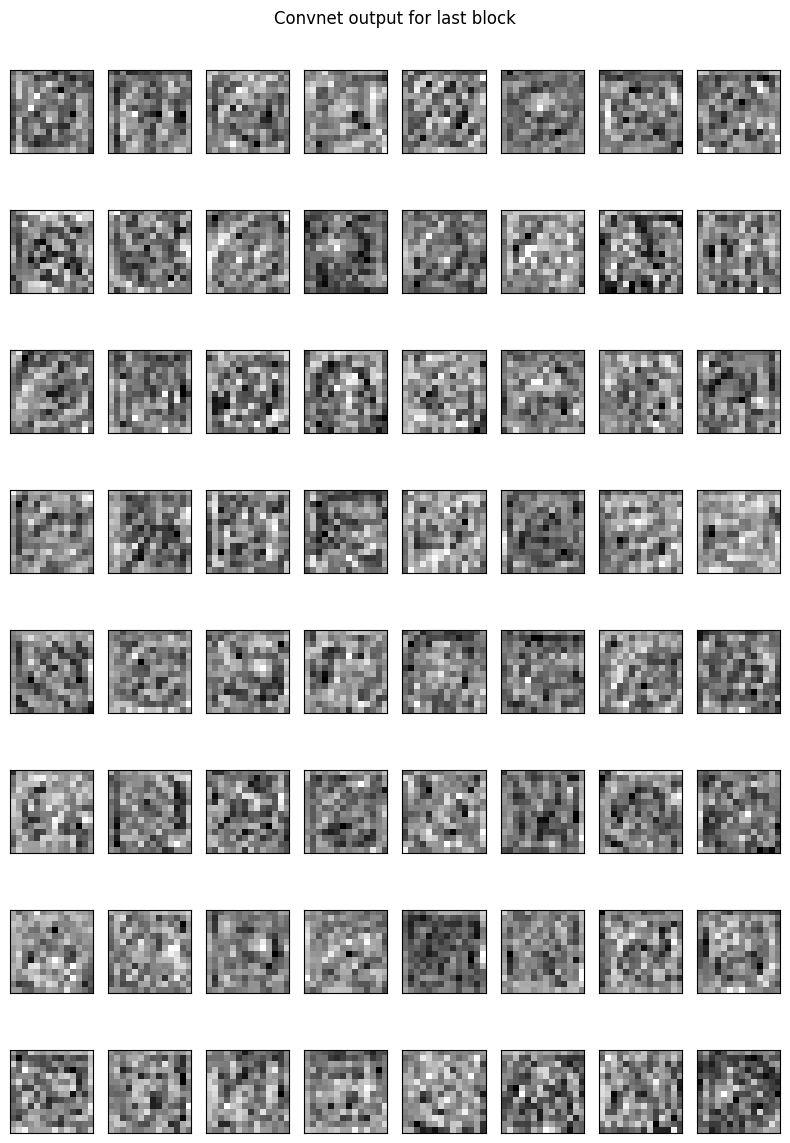

In [22]:
# Intermediate convnet outputs ('intermediate activations') visulization for last block on model_ft
conv_out_last_ft = FeatureExtractor(model_ft.layer4[0].seq, 0)
_ = model_ft(image)
conv_out_last_ft.remove()
conv_out_last_ft = conv_out_last_ft.output

print(conv_out_last_ft.shape)
plt_grid(title='Convnet output for last block', figsize=(8, 12), nrow=8, ncol=8, data=conv_out_last_ft)

torch.Size([512, 512, 3, 3])


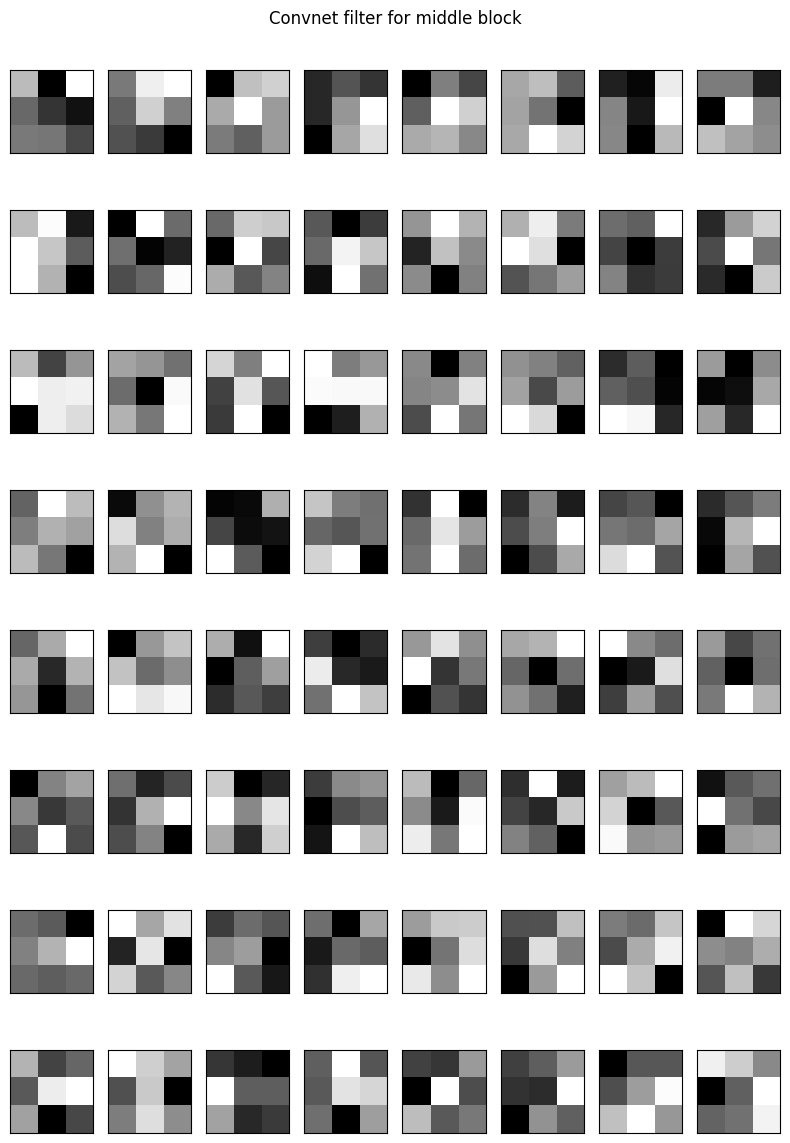

In [23]:
# Convnet filters visulization for last block on model_ft
conv_filter_last_ft = model_ft.layer4[0].seq[3]
weight_last_ft = next(conv_filter_last_ft.parameters())

print(weight_last_ft.shape)
plt_grid(title='Convnet filter for middle block', figsize=(8, 12), nrow=8, ncol=8, data=weight_last_ft)

torch.Size([1, 7, 7])


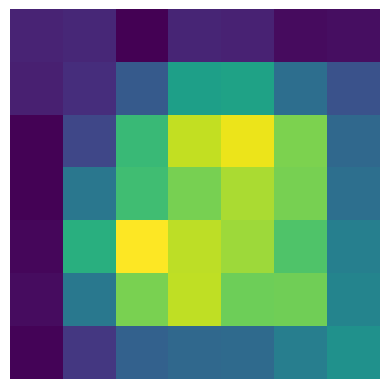

In [24]:
# Activation heatmap visulization for last block on model_ft
activate_out_last_ft = FeatureExtractor(model_ft.layer4, 2)
_ = model_ft(image)
activate_out_last_ft.remove()
activate_out_last_ft = activate_out_last_ft.output
activate_out_last_ft = activate_out_last_ft.mean(dim=1)

print(activate_out_last_ft.shape)
plt_heatmap(title='Activation heatmap for last block', data=activate_out_last_ft)